# Compare the effective bit width of ADPQ 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

In [2]:
symmetrical_quantization = True
bit_quantization = 4
group_size = 128
alpha = 0.09

model_size = 8*10**9 # Llama 3.1 8B
original_size_bytes = model_size * 2 # fp16

In [3]:
# All weights are quantized to 4-bit
def get_total_size_bytes(model_size, bit_quantization, group_size, alpha, symmetrical_quantization):
    quantized_weight_size_bytes = model_size * bit_quantization / 8

    scale_size_bytes = model_size / group_size * 2 # fp16 scales
    zero_point_size_bytes = 0 if symmetrical_quantization else model_size / group_size * 1 # int8 zero points

    index_outlier_size_bytes = model_size * alpha * np.log2(group_size) / 8 # bits to bytes, assuming ideal quantization

    total_size_bytes = quantized_weight_size_bytes + scale_size_bytes + zero_point_size_bytes + index_outlier_size_bytes

    effective_bits = total_size_bytes / model_size * 8

    return total_size_bytes, effective_bits, (scale_size_bytes, zero_point_size_bytes, index_outlier_size_bytes)

In [4]:
total_size_bytes, effective_bits, breakdown = get_total_size_bytes(model_size, bit_quantization, group_size, alpha, symmetrical_quantization)
effective_bits

np.float64(4.755)

## Plot

In [5]:
SoTA = {
    "RTN": 4.25,
    "AWQ": 4.27,
    "SpQR": 4.63,
    "BnB": 5.7 * 10**9 / (model_size) *8
}

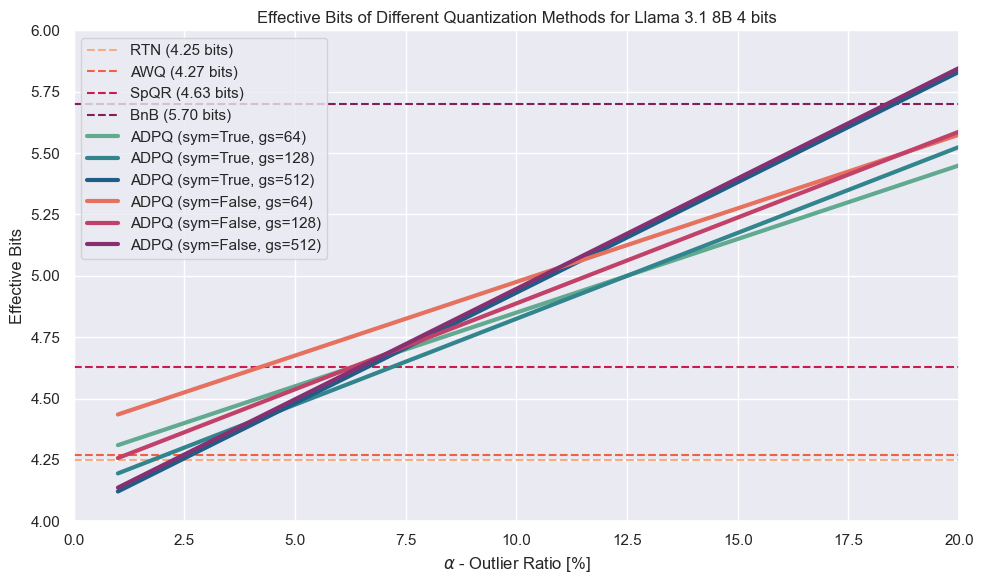

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

# horizontal line for SoTA
colors = sns.color_palette("rocket_r", len(SoTA)+1)
for i, (method, eb) in enumerate(SoTA.items()):
    ax.hlines(eb, xmin=0, xmax=20, colors=colors[i], linestyles='dashed', label=f'{method} ({eb:.2f} bits)')

for sym in [True, False]:
    range_gs = [64, 128, 512]
    colors = sns.color_palette("crest", len(range_gs)) if sym else sns.color_palette("flare", len(range_gs))

    for gs in range_gs:
        alphas = np.linspace(0.01, 0.2, 20)
        effective_bits_list = []
        for alpha in alphas:
            _, eb, _ = get_total_size_bytes(model_size, bit_quantization, gs, alpha, sym)
            effective_bits_list.append(eb)
        label = f'ADPQ (sym={sym}, gs={gs})'

        ax.plot(alphas*100, effective_bits_list, label=label, color=colors[range_gs.index(gs)], linewidth=3)

ax.set_title(f'Effective Bits of Different Quantization Methods for Llama 3.1 {model_size/10**9:.0f}B 4 bits')
ax.set_xlabel(r'$\alpha$ - Outlier Ratio [%]')
ax.set_ylabel('Effective Bits')
ax.set_xlim(0,20)
ax.set_ylim(4,6)
ax.legend()

fig.tight_layout()

plt.savefig('figs/effective_bits_vs_alpha.png', dpi=300)
plt.savefig('figs/effective_bits_vs_alpha.pdf')

## Compare PPL with effective bits

C:\Users\thoma\AppData\Local\Temp\ipykernel_36660\963141615.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(vals["effective_bits"], vals["ppl"], label=f'{method} (PPL={vals["ppl"]:.4f})', s=100, c=color[j])


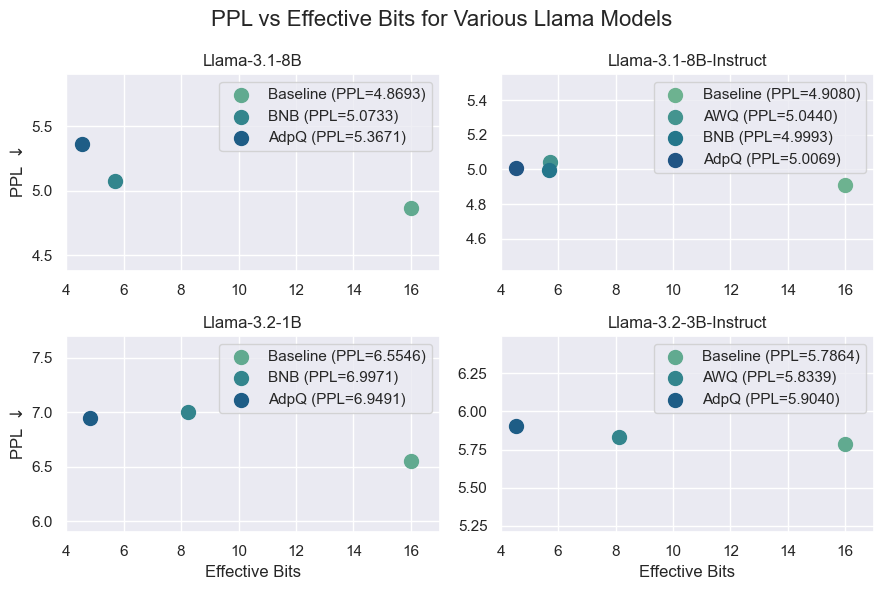

In [7]:
fig, axs = plt.subplots(2,2, figsize=(9,6))

models = {
    "Llama-3.1-8B": {
        "Baseline": {"path": "unsloth/Llama-3.1-8B", "ppl": 4.8693, "effective_bits": 16},
        "BNB":      {"path": "unsloth/Llama-3.1-8B-bnb-4bit", "ppl": 5.0733, "effective_bits": 5.7 * 10**9 / (8*10**9) *8},
        "AdpQ":     {"path": "Tfloow/Llama-3.1-8B-adpq-4bit-sim", "ppl": 5.3671, "effective_bits": get_total_size_bytes(8*10**9, 4, 128, 0.05, False)[1]}
    },
    "Llama-3.1-8B-Instruct": {
        "Baseline": {"path": "meta-llama/Llama-3.1-8B-Instruct", "ppl": 4.9080, "effective_bits": 16},
        "AWQ":      {"path": "hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4", "ppl": 5.0440, "effective_bits": (4.68+1.05) * 10**9 / (8*10**9) *8},
        "BNB":      {"path": "hugging-quants/Meta-Llama-3.1-8B-Instruct-BNB-NF4", "ppl": 4.9993, "effective_bits": (4.65+1.05) * 10**9 / (8*10**9) *8},
        #"GPTQ":     {"path": "hugging-quants/Meta-Llama-3.1-8B-Instruct-GPTQ-INT4", "ppl": float('nan'), "effective_bits": (4.97+0.764) * 10**9 / (8*10**9) *8},
        "AdpQ":     {"path": "Tfloow/Llama-3.1-8B-Instruct-adpq-4bit-sim", "ppl": 5.0069, "effective_bits": get_total_size_bytes(8*10**9, 4, 128, 0.05, False)[1]}
    },
    "Llama-3.2-1B": {
        "Baseline": {"path": "unsloth/Llama-3.2-1B", "ppl": 6.5546, "effective_bits": 16},
        "BNB":      {"path": "unsloth/Llama-3.2-1B-bnb-4bit", "ppl": 6.9971, "effective_bits": 1.03 * 10**9 / (10**9) *8},
        "AdpQ":     {"path": "Tfloow/Llama-3.2-1B-adpq-4bit-sim", "ppl": 6.9491, "effective_bits": get_total_size_bytes(10**9, 4, 128, 0.09, False)[1]}
    },
    "Llama-3.2-3B-Instruct": {
        "Baseline": {"path": "meta-llama/Llama-3.2-3B-Instruct", "ppl": 5.7864, "effective_bits": 16},
        "AWQ":      {"path": "AMead10/Llama-3.2-3B-Instruct-AWQ", "ppl": 5.8339, "effective_bits": 3.04 * 10**9 / (3*10**9) *8},
        "AdpQ":     {"path": "Tfloow/Llama-3.2-3B-Instruct-adpq-4bit-sim", "ppl": 5.9040, "effective_bits": get_total_size_bytes(3*10**9, 4, 128, 0.05, False)[1]}
    }
}

for i, (k,v) in enumerate(models.items()):
    ax = axs[i//2, i%2]
    color = sns.color_palette("crest", len(v))
    max_PPL = max([vals["ppl"] for vals in v.values()])
    min_PPL = min([vals["ppl"] for vals in v.values()])

    for j, (method, vals) in enumerate(v.items()):
        ax.scatter(vals["effective_bits"], vals["ppl"], label=f'{method} (PPL={vals["ppl"]:.4f})', s=100, c=color[j])

    if i//2:
        ax.set_xlabel('Effective Bits')
    if not i%2:
        ax.set_ylabel(r'PPL $\downarrow$')

    ax.set_xlim(4,17)
    ax.set_ylim(min_PPL*0.9,max_PPL*1.1)
    ax.legend()
    ax.set_title(k)

fig.suptitle('PPL vs Effective Bits for Various Llama Models', fontsize=16)
fig.tight_layout()

plt.savefig('figs/ppl_vs_effective_bits.png', dpi=300)
plt.savefig('figs/ppl_vs_effective_bits.pdf')